In [1]:
import tensorflow as tf 
from tensorflow import keras 
import tensorflow_addons as tfa
import tensorflow_hub as hub 
from sklearn.metrics import mean_absolute_error 
import numpy as np 
import datetime
from deepface import DeepFace

c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Load data

In [2]:
train_ds = tf.data.Dataset.load('./data/videofaces/train_ds') \
    .cache().shuffle(buffer_size=1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.load('./data/videofaces/val_ds') \
    .cache().shuffle(buffer_size=1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds, valid_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 152, 152, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 152, 152, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

### Load DeepFace

In [3]:
# Define DeepFace model
def load_deepface_model():
    deepface = DeepFace.build_model('DeepFace')  # Load the DeepFace model
    return deepface.model  # Return the model

# Load the model
deepface_model = load_deepface_model()

# Confirm the model is loaded by checking its summary
deepface_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1_input (InputLayer)       [(None, 152, 152, 3)]     0         
                                                                 
 C1 (Conv2D)                 (None, 142, 142, 32)      11648     
                                                                 
 M2 (MaxPooling2D)           (None, 71, 71, 32)        0         
                                                                 
 C3 (Conv2D)                 (None, 63, 63, 16)        41488     
                                                                 
 L4 (LocallyConnected2D)     (None, 55, 55, 16)        62774800  
                                                                 
 L5 (LocallyConnected2D)     (None, 25, 25, 16)        7850000   
                                                                 
 L6 (LocallyConnected2D)     (None, 21, 21, 16)        282945

### Build Face model

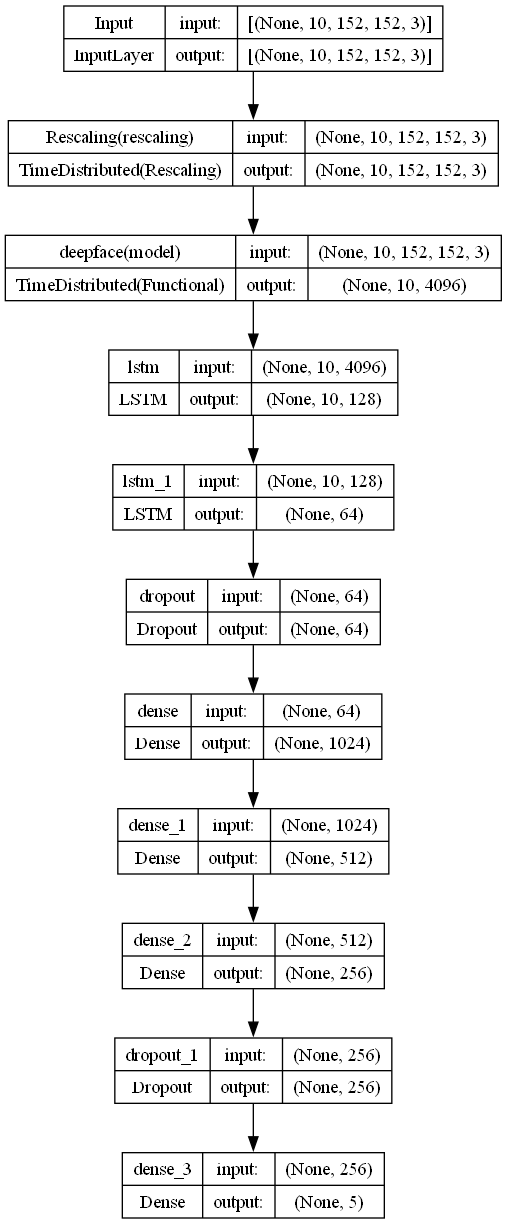

In [4]:
inputs = keras.layers.Input(shape=(10,152,152,3), name='Input')

x      = keras.layers.TimeDistributed(keras.layers.Rescaling(scale=1./255.0), name='Rescaling')(inputs)
x      = keras.layers.TimeDistributed(deepface_model, name='deepface')(x)

x      = keras.layers.LSTM(units=128, return_sequences=True)(x)
x      = keras.layers.LSTM(units=64)(x)

x      = keras.layers.Dropout(0.2)(x)

x      = keras.layers.Dense(units=1024)(x)
x      = keras.layers.Dense(units=512, activation='relu')(x)

x      = keras.layers.Dense(256, activation='relu')(x)
x      = keras.layers.Dropout(0.5)(x)

x      = keras.layers.Dense(5, activation='sigmoid')(x)

model  = keras.models.Model(inputs=inputs, outputs=x)
keras.utils.plot_model(model, show_shapes=True)

### Compile model

In [5]:
t = datetime.datetime.now().strftime("%m%d_%H%M%S")

# optimizer = keras.optimizers.Adam(learning_rate=0.001)
# optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
optimizer = tfa.optimizers.RectifiedAdam(learning_rate=0.001)

early_stopping = keras.callbacks.EarlyStopping(patience=10, verbose=0)
check_point    = keras.callbacks.ModelCheckpoint(filepath='./weights/faces/'+str(t)+'/face.t5',
                            monitor='val_mae',
                            mode='min',
                            save_best_only=True,
                            save_weights_only=True,
                            verbose=0)

model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

### Train

In [6]:
history = model.fit(train_ds, validation_data=valid_ds, batch_size=4, epochs=100, callbacks=[early_stopping, check_point])

Epoch 1/100


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model_1/deepface/model/L4/strided_slice_1779/StridedSliceGrad' defined at (most recent call last):
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\SIA\AppData\Local\Temp\ipykernel_3692\3610260969.py", line 1, in <module>
      history = model.fit(train_ds, validation_data=valid_ds, batch_size=4, epochs=100, callbacks=[early_stopping, check_point])
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\keras\engine\training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\keras\optimizers\legacy\optimizer_v2.py", line 585, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\keras\optimizers\legacy\optimizer_v2.py", line 643, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\SIA\anaconda3\envs\deepface-env\lib\site-packages\keras\optimizers\legacy\optimizer_v2.py", line 519, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model_1/deepface/model/L4/strided_slice_1779/StridedSliceGrad'
OOM when allocating tensor with shape[30,63,63,16] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/model_1/deepface/model/L4/strided_slice_1779/StridedSliceGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_253567]

### Load weights

In [ ]:
model.load_weights('./weights/faces/face.t5')

## Evaluation

### Training data

In [ ]:
train_ds = tf.data.Dataset.load('./data/videofaces/train_ds') 
loss, mae = model.evaluate(train_ds)
(1-mae)*100

In [ ]:
y_true = np.concatenate([y for x,y in train_ds])
y_pred = model.predict(train_ds)

mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
(1-mae)*100, (1-np.mean(mae))*100

### Validation data

In [ ]:
valid_ds = tf.data.Dataset.load('./data/videofaces/val_ds') 
loss, mae = model.evaluate(valid_ds)
(1-mae)*100

In [ ]:
y_true = np.concatenate([y for x,y in valid_ds])
y_pred = model.predict(valid_ds)

mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
(1-mae)*100, (1-np.mean(mae))*100

### Test data

In [ ]:
test_ds = tf.data.Dataset.load('./data/videofaces/test_ds/')
loss, mae = model.evaluate(test_ds)
(1-mae)*100

In [ ]:
y_true = np.concatenate([y for x,y in test_ds])
y_pred = model.predict(test_ds)

mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
(1-mae)*100, (1-np.mean(mae))*100